# Self Assembling Function Annotations

[PEP 3107]() introduces functions annotations and [PEP 484](https://www.python.org/dev/peps/pep-0484/) discusses semantics for doing so.

In [1]:
from whatever.automaton import build, nx
%matplotlib inline

## Simple example

Below is a simple example of type annotations.  At runtime, an annotated function has a non-empty attribute `__annotations__`.

In [2]:
def greeting(name: str) -> str:
    return 'Hello ' + name
greeting.__annotations__

{'name': str, 'return': str}

It doesn't seem that there are restrictions annotations.

In [18]:
def greeting2(name: (lambda x: str.upper(x) if len(x) < 5 else x)) -> str:
    return 'Hello ' + name
greeting2.__annotations__

{'name': <function __main__.<lambda>>, 'return': str}

## Exploiting Annotations

> A slick way to require functions.

The annotations in the functions below indicate either:

* user-provided parameters defined by strings
* other function references that must complete before executing the function

In [19]:
def f(a: 'A'):
    return a

def g(a: f, b: 'B'):
    return a+b

def h(a: f, b: g):
    return a*b

* `f` requires a parameters named `A`
* `g` requires `f` to complete and a parameter named `B`
* `h` requires `g` and `h` complete before executing.

## `whatever.automaton`

`whatever.automaton.build` composes an in-memory task graph that executes the functions in the appropriate order.

In [29]:
# Compose the higher-order function
F = build(f, h, globals()) # F = consume(f, h, IPython.get_ipython().user_ns)

In [30]:
F(A=10, B=32).node['h']['value']

420

In [31]:
F(A=32, B=10).node['h']['value']

1344

In [32]:
import IPython.display as display
import sklearn.datasets, sklearn.discriminant_analysis, sklearn.metrics
from whatever.harness import Harness

In [33]:
def load(alias: 'ALIAS'):
    data = getattr(sklearn.datasets, 'load_'+alias)()
    return Harness(
        data=data['data'],
        index=data['target'],
    )

In [34]:
def model(df: load):
    return df.set_params(
        estimator=sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),
        feature_level=-1,
    )

In [35]:
def fit(df: model, samples: 'SAMPLES'):
    df.sample(samples).fit()
    return df

In [36]:
def transform_and_predict(df: fit):
    return df.transform().set_index(df.predict()[0].values, append=True)

In [37]:
def analyze(df: transform_and_predict):
    ys = df.index.get_level_values(0), df.index.get_level_values(1)
    score = sklearn.metrics.classification.accuracy_score(*ys)
    confusion = Harness(sklearn.metrics.confusion_matrix(*ys))
    return display.display(
        display.Markdown(
            """The score is {}.""".format(score)
        ),
        display.Markdown(
            """### The confusion matrix"""
        ),
        display.HTML(confusion.to_html()),
    )
    

In [38]:
F = build(load, analyze)

In [41]:
F(SAMPLES=20, ALIAS='iris');

The score is 0.9733333333333334.

### The confusion matrix

,0,1,2
0,50,0,0
1,0,48,2
2,0,2,48


In [42]:
F(SAMPLES=100, ALIAS='iris');

The score is 0.98.

### The confusion matrix

,0,1,2
0,50,0,0
1,0,48,2
2,0,1,49


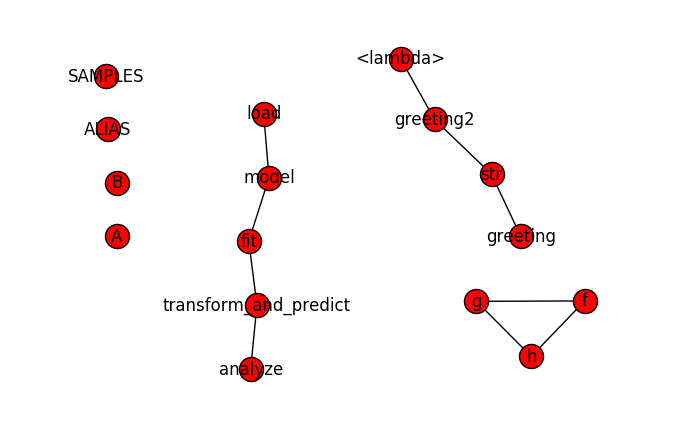

In [43]:
pos = nx.nx_pydot.graphviz_layout(F.args[0])
nx.draw(F.args[0], pos)
nx.draw_networkx_labels(F.args[0], pos)
pass